In [1]:
import torch
from tqdm import tqdm
from CB2CFMultiModalEncoder import CB2CFMultiModalEncoder
import matplotlib.pyplot as plt


c:\Users\tsale\OneDrive\Desktop\CS Masters Degree\Recommendation Systems\Project\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load cb2cf_train_dataset with torch
training_data = torch.load("cb2cf_train_dataset.pt")

train_size = int(0.9 * len(training_data))
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])


In [3]:
# Create CB2CFTransformer model
number_of_genres = train_dataset[0]["genres"].shape[0]
number_of_actors = train_dataset[0]["actors"].shape[0]
number_of_directors = train_dataset[0]["directors"].shape[0]
number_of_languages = train_dataset[0]["language"].shape[0]
item_embedding_dim = train_dataset[0]["embeddings"].shape[0]


model = CB2CFMultiModalEncoder(
    number_of_genres=number_of_genres,
    number_of_actors=number_of_actors,
    number_of_directors=number_of_directors,
    number_of_languages=number_of_languages,
    item_embedding_dim=item_embedding_dim,
    dropout=0.2,
)


In [4]:
criterion = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)


Using device: cuda:0


In [5]:
# Create train and validation dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Train the model
num_epochs = 30
train_loss_history = []
val_loss_history = []
should_early_stop = False

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        output = model(
            genres=batch["genres"].to(device),
            actors=batch["actors"].to(device),
            directors=batch["directors"].to(device),
            unix_release_time=batch["unix_release_time"].to(device),
            description=batch["description"],
            language=batch["language"].to(device),
        )
        loss = criterion(output, batch["embeddings"].to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            # genres, actors, directors, unix_release_time, description, language
            output = model(
                genres=batch["genres"].to(device),
                actors=batch["actors"].to(device),
                directors=batch["directors"].to(device),
                unix_release_time=batch["unix_release_time"].to(device),
                description=batch["description"],
                language=batch["language"].to(device),
            )
            loss = criterion(output, batch["embeddings"].to(device))
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)

    if len(val_loss_history) > 4:
        if val_loss_history[-1] > val_loss_history[-2] > val_loss_history[-3] > val_loss_history[-4]:
            print("Early stopping")
            should_early_stop = True
            break
    print(f"Epoch {epoch}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")


100%|██████████| 14/14 [00:00<00:00, 17.30it/s]


Epoch 0: train loss = 0.6152, val loss = 0.5295


100%|██████████| 14/14 [00:00<00:00, 17.74it/s]


Epoch 1: train loss = 0.5616, val loss = 0.5075


100%|██████████| 14/14 [00:00<00:00, 17.82it/s]


Epoch 2: train loss = 0.5412, val loss = 0.4860


100%|██████████| 14/14 [00:00<00:00, 17.70it/s]


Epoch 3: train loss = 0.5233, val loss = 0.4726


100%|██████████| 14/14 [00:00<00:00, 17.89it/s]


Epoch 4: train loss = 0.5138, val loss = 0.4704


100%|██████████| 14/14 [00:00<00:00, 17.79it/s]


Epoch 5: train loss = 0.5064, val loss = 0.4633


100%|██████████| 14/14 [00:00<00:00, 17.78it/s]


Epoch 6: train loss = 0.4991, val loss = 0.4605


100%|██████████| 14/14 [00:00<00:00, 17.76it/s]


Epoch 7: train loss = 0.4958, val loss = 0.4573


100%|██████████| 14/14 [00:00<00:00, 17.83it/s]


Epoch 8: train loss = 0.4873, val loss = 0.4543


100%|██████████| 14/14 [00:00<00:00, 17.80it/s]


Epoch 9: train loss = 0.4835, val loss = 0.4526


100%|██████████| 14/14 [00:00<00:00, 17.63it/s]


Epoch 10: train loss = 0.4828, val loss = 0.4512


100%|██████████| 14/14 [00:00<00:00, 17.68it/s]


Epoch 11: train loss = 0.4795, val loss = 0.4518


100%|██████████| 14/14 [00:00<00:00, 17.76it/s]


Epoch 12: train loss = 0.4749, val loss = 0.4509


100%|██████████| 14/14 [00:00<00:00, 17.80it/s]


Epoch 13: train loss = 0.4746, val loss = 0.4496


100%|██████████| 14/14 [00:00<00:00, 17.60it/s]

Epoch 14: train loss = 0.4718, val loss = 0.4517


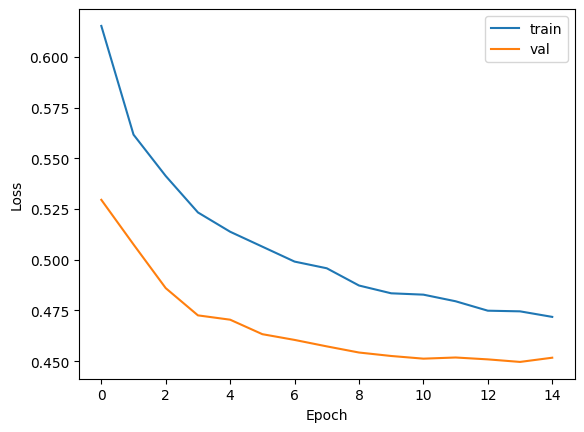

In [7]:
# Plot the loss curves for epochs


plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save the model
# torch.save(model.state_dict(), "cb2cf_multi_modal_encoder_model.pt")
